In [1]:
import numpy as np
import matplotlib.pyplot as plt


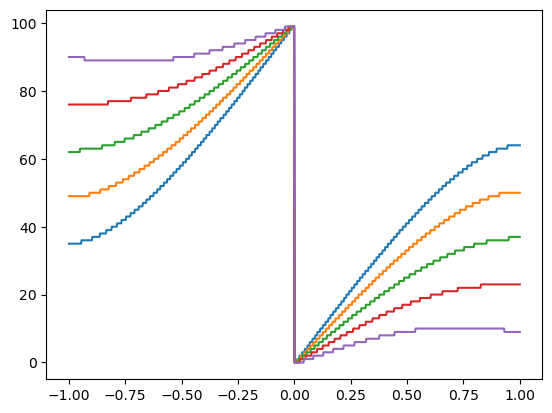

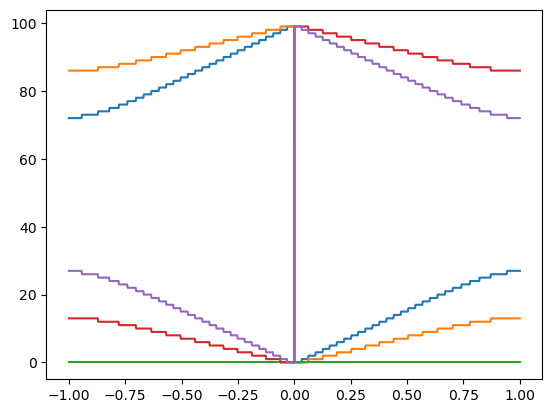

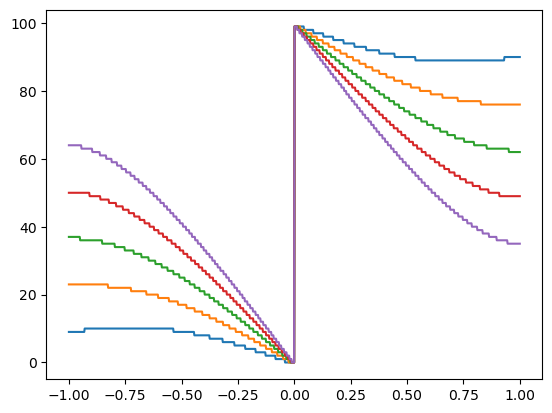

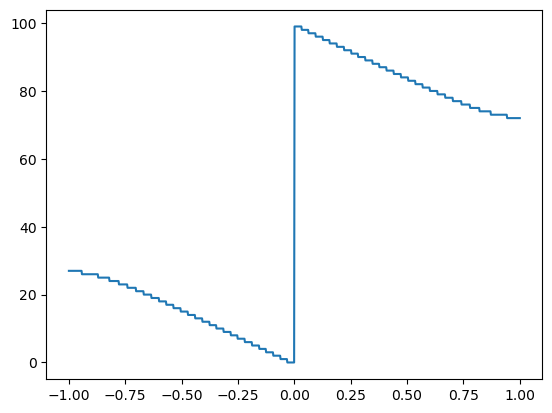

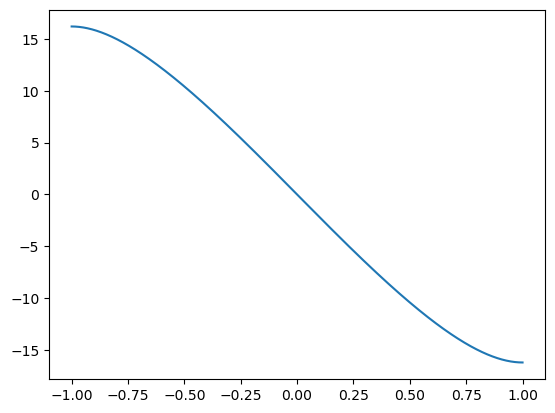

In [23]:
num_phases = 100

def calcPhaseCont(x,B,N):
    phase = (1*((B*x**7)/7-B*x)-7*((N*x**3)/6-N*x/2))
    return phase

def calcPhase(x, B, N):
    global num_phases
    junction_width = 3
    anti_dot_size = 1
    
    phase = calcPhaseCont(x,B,N)
#     phase = y = 2.5 * (np.tanh(B * x) + 1)#phase is linear
#     if(x > -anti_dot_size/2 and x < anti_dot_size/2):
#         phase = phase - N*(x+anti_dot_size/2)/anti_dot_size
#     elif (x >= anti_dot_size/2):
#         phase = phase - N
#     rtv = int(np.round(np.mod(phase/(2*np.pi),num_phases)))
    rtv = int((np.mod(num_phases*phase/(2*np.pi),num_phases)))
    if(rtv == num_phases):#Fix when rtv rounds above 3
        rtv = 0
        
    return rtv

xx = np.linspace(-1,1,1000)

N = 1
for B in np.linspace(-2,2,5):
    yy = [calcPhase(x_i, B, N) for x_i in xx]
    plt.plot(xx,yy)
plt.show()
    
N = 0
for B in np.linspace(-2,2,5):
    yy = [calcPhase(x_i, B, N) for x_i in xx]
    plt.plot(xx,yy)
plt.show()

N = -1
for B in np.linspace(-2,2,5):
    yy = [calcPhase(x_i, B, N) for x_i in xx]
    plt.plot(xx,yy)
plt.show()

yyyy = [calcPhase(x_i, 2, 0) for x_i in xx]
plt.plot(xx, yyyy)
plt.show()

y6 = 4*(1*((B*xx**7)/7-B*xx)-7*((N*xx**3)/6-N*xx/2))
plt.plot(xx, y6)
plt.show()

Text(0.5, 1.0, 'IC sweep for N=0')

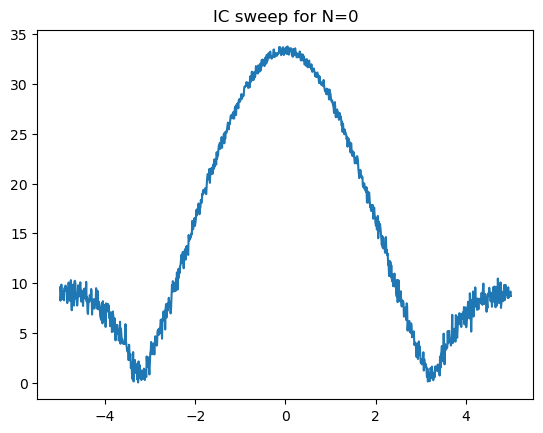

In [51]:
num_channels = 30
jj_channels = np.random.uniform(-1, 1, num_channels)#This needs to break the left-right symmetry otherwise the kernel will always be non-empty when N_ch != 1

#Note, this function must be an odd function
def simulated_cpr(phase):
    return np.sin(phase) #+ np.sin(3*phase)

def calculate_ic(N, B):
    jj_channels_hidden = np.random.uniform(-1, 1, 1000) #Nature has many channels
    current = 0
    for channel_num, channel_pos in enumerate(jj_channels_hidden):
        current += simulated_cpr(np.pi/2 + calcPhaseCont(channel_pos, B, N))
    return current/30 + 0.5 * np.random.uniform(-1,1)

N = 0
num_channels = 30
num_phases = 1000
b_range = np.linspace(-5,5,1000)
ic_for_plot = [abs(calculate_ic(0, b)) for b in b_range]
plt.plot(b_range, ic_for_plot)
plt.title("IC sweep for N=0")

In [38]:
num_phases = 100
num_channels = 20

# vortex_counts = [-2, -1.5, -1, -0.5, 0, 1, 2]
vortex_counts = [2, -1, 0, 1, 2]
B_points = 2000

if(B_points * len(vortex_counts) < num_phases*num_channels):
    print("ERROR: NEED MORE DATA POINTS")
    
cpr_matrix = np.zeros((len(vortex_counts)*B_points,num_phases*num_channels))
critical_currents = []

jj_channels = np.random.uniform(-1, 1, num_channels)#This needs to break the left-right symmetry otherwise the kernel will always be non-empty when N_ch != 1

#Construct CPR matrix and critical current vector
row_num = 0
for B in np.linspace(-5,5,B_points):
    for N in vortex_counts:
        for channel_num, channel_pos in enumerate(jj_channels):
            cpr_matrix[row_num,channel_num*num_phases+calcPhase(channel_pos, B, N)] = 1
        row_num = row_num+1
        critical_currents.append(calculate_ic(N, B))

# print(critical_currents)
print("Matrix Constructed")
# Find the least-squares solution, Moore Penrose pseudoinverse
x_ls, residuals, rank, s = np.linalg.lstsq(cpr_matrix, critical_currents, rcond=None)
print("Least Squares complete")

# Find the null space of cpr_matrix
if(True):
    U, S, Vt = np.linalg.svd(cpr_matrix)
    null_mask = (S <= 1e-10)
    null_space = np.compress(null_mask, Vt, axis=0)
    print("Decomposition complete")
    print("Kernel Dim: " + str(np.sum(null_mask)))
    print("Rank:" + str(rank))

x1 = x_ls #This is the smallest 2-norm? Filters out chaotic solutions. Really kernel dim should be zero


Matrix Constructed
Least Squares complete
Decomposition complete
Kernel Dim: 392
Rank:1608


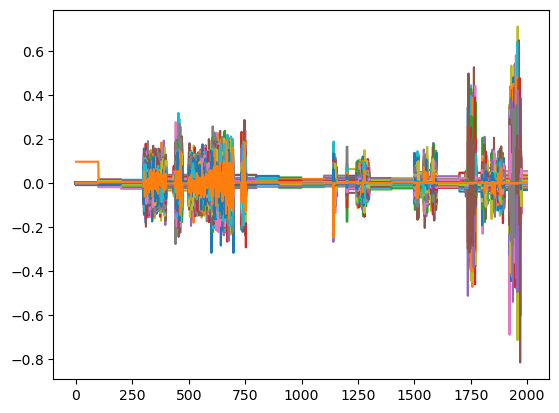

Number of channels to select: 9
Select a channel number: 0
Select a channel number: 1
Select a channel number: 2
Select a channel number: 8
Select a channel number: 9
Select a channel number: 10
Select a channel number: 13
Select a channel number: 14
Select a channel number: 16


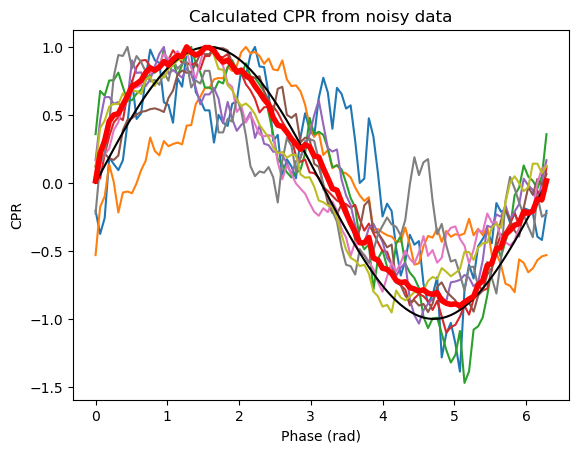

In [41]:
###### x_space = np.linspace(0,2*np.pi,num_phases)

for i in range(len(null_space)):
    x1_new = null_space[i]
    plt.plot(x1_new[:]-np.average(x1_new[:]))
plt.show()

ch_nums = []
for i in range(int(input("Number of channels to select: "))):
    ch_nums.append(int(input("Select a channel number: ")))

    # PLOT KERNEL FOR JUST SELECTED CHANNEL
#     for i in range(len(null_space)):
#         x1_new = null_space[i]
#         plt.plot(x1_new[num_phases*ch_num:num_phases*(ch_num+1)]-np.average(x1_new[num_phases*ch_num:num_phases*(ch_num+1)]))
#     plt.show()

    #PLOT JUST SELECTED CHANNEL
#     x1_ch_sel = x1[num_phases*ch_num:num_phases*(ch_num+1)]
#     plt.plot(x_space, x1_ch_sel-np.average(x1_ch_sel))
#     plt.show()

    #Plot comparison of CPR
ch_sels = []    

for ch_num in ch_nums:
    ch_sel = x1[num_phases*ch_num:num_phases*(ch_num+1)]
    ch_sels.append(ch_sel)
    
    theoretical_cpr = simulated_cpr(x_space)
    calculated_cpr = [ch_sel[int(num_phases*x/(2*np.pi))] for x in x_space-np.pi/2]

    plt.plot(x_space, calculated_cpr/max(calculated_cpr))
plt.plot(x_space, theoretical_cpr, c="black")
    
    
average_cpr = np.mean(np.stack(ch_sels), axis=0)/max(np.mean(np.stack(ch_sels), axis=0))
plt.plot(x_space, [average_cpr[int(num_phases*x/(2*np.pi))] for x in x_space-np.pi/2], c="red", linewidth=4)
plt.ylabel("CPR")
plt.xlabel("Phase (rad)")
plt.title("Calculated CPR from noisy data")
plt.show()
